In [1]:
# Library
import os
import numpy as np
from numpy.random import randint
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.metrics import Precision
from keras.layers import Flatten, Dropout, Dense, Activation
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.applications import vgg19, ResNet50V2
# Set path
%cd C:\Users\user\Desktop\KUL - Mstat\Big Data Platforms and Technologies\project2

C:\Users\user\Desktop\KUL - Mstat\Big Data Platforms and Technologies\project2


**<font color='blue'>The second part of your lab report should contain:</font>**
- <font color='blue'>Overview of your full deep learning pipe line, including architecture, trade-offs, ways used to prevent overfitting</font>
- <font color='blue'>Results based on your chosen evaluation metric</font>
- <font color='blue'>Illustration of your model's predictions on a test image (or one of your own)</font>
- <font color='blue'>Style points if you test out your model on a picture of your own (e.g. using FastAPI / Shiny / Flask / …)</font>
- <font color='blue'>Style points if you apply some interpretability techniques</font>
- <font color='blue'>You don’t need a beefy machine / GPU! Downscale images, use transfer learning with a pretrained model / image augmentation, ...</font>

In [2]:
# Read guideline
receipes = pd.read_csv(os.getcwd() + r'\\recipes.csv', sep = ';')
# Read tag
tag = pd.read_table(os.getcwd() + r'\\tag_merge.txt', sep = ',', header = None, skipinitialspace=True)

In [3]:
receipes.head(3)

,photo_id,url,may_be,likes,timestamp,scraped_at,diff,tag_healthy,tag_tasty,tag_dinner,...,tag_egg,tag_oatmeal,tag_natural,tag_beef,tag_noodles,tag_italian,tag_drinks,tag_steak,tag_sandwich,tag_strawberry
0,CMPELQqh_nh,https://www.instagram.com/p/CMPELQqh_nh/,dessert and indoor,3,2021-03-10T10:47:18,2021-03-10T11:48:52,1.03,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,CMPEHqppR-t,https://www.instagram.com/p/CMPEHqppR-t/,pasta and indoor,3,2021-03-10T10:46:48,2021-03-10T11:48:59,1.04,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CMPEBY9Buko,https://www.instagram.com/p/CMPEBY9Buko/,cake and indoor,2,2021-03-10T10:45:57,2021-03-10T11:49:08,1.05,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Transform tag's into a dictionary {'old tag': 'new tag'}
newheader = tag[0]
tag_dict = tag.T.iloc[[1]]
tag_dict.columns = newheader.values
tag_dict = tag_dict.T.to_dict()[1]

In [5]:
len(tag_dict)

50

<font color='red'>There seems to be too many labels...</font>

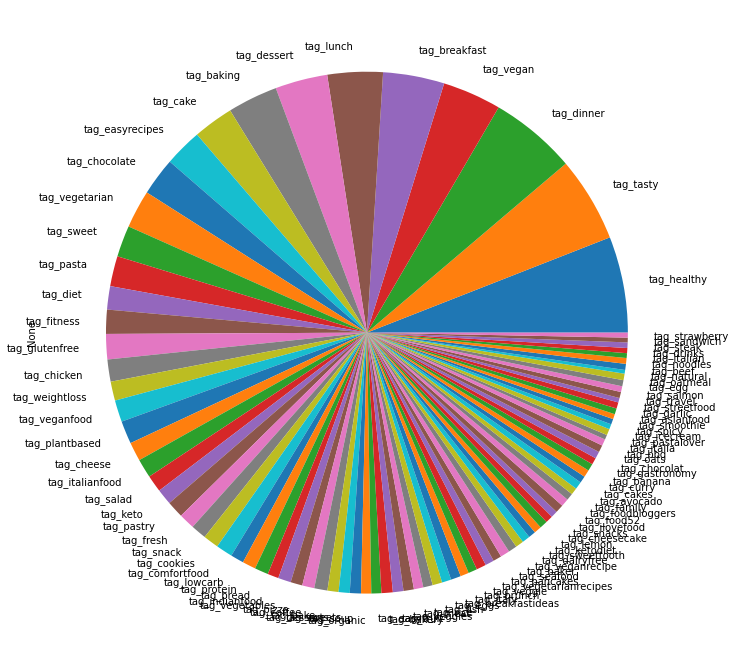

In [6]:
# Class distribution
column_tag = receipes.columns.to_series().str.startswith('tag_')
column_tag = receipes.columns[column_tag]
receipes[column_tag].sum().plot.pie(figsize = (12, 12))

<font color='red'>Image processing </font>

In [7]:
# Load data
def load_data(IMGSIZE):
    images, labels = list(), list()
    for ind, photo_id in enumerate(receipes['photo_id']):
        # In case of empty image, load_img() gives warnings, use try except here
        try:
            IMGPATH = r'\recipes\recipes' + '\\' + photo_id + '.png'
            image = load_img(os.getcwd() + IMGPATH, target_size = IMGSIZE)
            label = receipes.iloc[ind][column_tag] == 1
            images.append(img_to_array(image))
            labels.append(column_tag[label])
        except: 
            continue
    return images, labels

In [8]:
%%time
# (224, 224) for ResNet50V2 and VGG16
# It may take a while to run
IMGSIZE = (224, 224)
X, y = load_data(IMGSIZE)

Wall time: 2min 29s


<font color='red'>Randomly show you some images</font>

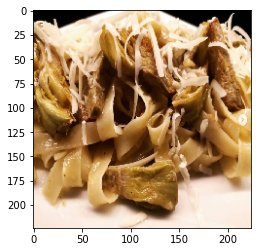

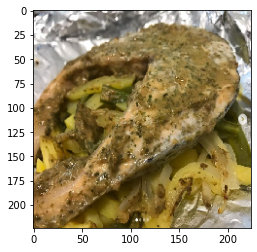

In [9]:
N = len(X)
rand_indices = randint(0, N, size = 2)
for ind in rand_indices:
    plt.imshow(array_to_img(X[ind]))
    plt.show()

<font color='red'>Too many labels, regroup them</font>

In [10]:
# Some tag are unrelated to types of food
drop_tag = ['tag_easyrecipes', 'tag_ilovefood', 'tag_food52', 'tag_foodbloggers', 'tag_family',
           'tag_glutenfree', 'tag_easy']

In [11]:
# Each element of yn contains a list of tags with nonzero values
def map_tag(tags):
    tag_merged = set()
    for tag in tags:
        if tag in tag_dict.keys():
            tag_merged.add(tag_dict[tag])
        elif tag not in drop_tag:
            tag_merged.add(tag)
    return list(tag_merged)
yn = [map_tag(tags) for tags in y]

In [12]:
# Update column names: Drop names appeared in drop_tag, group names tgt using tag_dict
new_labels = column_tag.drop(drop_tag).to_series().replace(tag_dict).values

In [13]:
# Convert each element of yn into an array using dictionary as mapping
def get_dict(tags):
    dict_temp = dict()
    for new_label, exist in zip(new_labels, [0] * len(new_labels)):
        if new_label in tags:
            exist = 1
        dict_temp[new_label] = exist
    return dict_temp
y_np = pd.DataFrame([get_dict(tags) for tags in yn]).to_numpy()

<font color='red'>Randomly sample some images given tag, some may look weird</font>

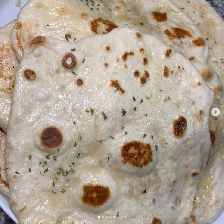

In [14]:
# Check some concepts
photo_id = receipes[receipes['tag_easy'] == 1].sample(1)['photo_id'].values[0]
IMGPATH = r'\recipes\recipes' + '\\' + photo_id + '.png'
load_img(os.getcwd() + IMGPATH, target_size = IMGSIZE)

In [15]:
# How many image belongs to such tag?
TAG = 'tag_easy'
receipes[receipes[TAG] == 1].shape[0]

148

--- 

<font color='red'> Rescaling & Train-test split</font>

In [16]:
%%time
# Rescaling input
X = np.array(X)/255

In [17]:
%%time 
# Train:Val:Test = 0.7:0.2:0.1
X_train, X_test, y_train, y_test = train_test_split(X, y_np, test_size = 0.1, random_state = 721)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 2/9, random_state = 831)

Wall time: 50.7 s


<font color='red'>Transfer learning models</font>

In [18]:
# The output shape
y_np[0].shape

(55,)

In [19]:
# A model for vgg19
def model_vgg19_wrap(FREEZE, input_shape, output_shape, drop_out_rate):
    vgg19_load = vgg19.VGG19(weights = 'imagenet', include_top = False, 
                             input_shape = input_shape)
    vgg19_load.trainable = FREEZE # Freeze the pretrained model
    model_vgg19 = Sequential()
    model_vgg19.add(vgg19_load) # Pretrained model
    model_vgg19.add(Flatten())
    model_vgg19.add(Dense(4096, activation = 'relu')) # Self-defined top layer
    model_vgg19.add(Dropout(drop_out_rate)) # Need dropout because VGG19 architecture does not have drop out
    model_vgg19.add(Dense(1024, activation = 'relu'))
    model_vgg19.add(Dropout(drop_out_rate))
    model_vgg19.add(Dense(512, activation = 'relu'))
    model_vgg19.add(Dropout(drop_out_rate))
    model_vgg19.add(Dense(output_shape, activation = 'softmax'))
    # Compile model
    model_vgg19.compile(loss = 'categorical_crossentropy', optimizer = 'adam',  
              metrics=['accuracy', Precision(), 'AUC'])
    return model_vgg19

In [20]:
# Compile a model
input_shape = ([224, 224, 3])
output_shape = 55
drop_out_rate = 0.5
model_vgg19 = model_vgg19_wrap(False, input_shape, output_shape, drop_out_rate)

<font color='red'>Data augmentation</font>

<font color='red'>Data augmentation on training data with parameters set in *aug_param*</font>

In [26]:
aug_param = {
    'featurewise_center': False,
    'featurewise_std_normalization': False,
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'horizontal_flip': True}
train_gen = ImageDataGenerator(**aug_param).flow(X_train, y_train, batch_size = 64)

<font color='red'>Create a generator for validation data *without* data augmentation</font>

In [27]:
val_gen = ImageDataGenerator().flow(X_val, y_val)

In [ ]:
%%time
train_param = {'generator': train_gen, 
               'validation_data': val_gen, 
               'validation_steps': 2,
               'workers': 10,
               'epochs': 120}
history = model_vgg19.fit_generator(**train_param)

Epoch 1/120
  1/128 [..............................] - ETA: 12:57 - loss: 2409553.0000 - accuracy: 0.0781 - precision: 0.0469 - auc: 0.5071

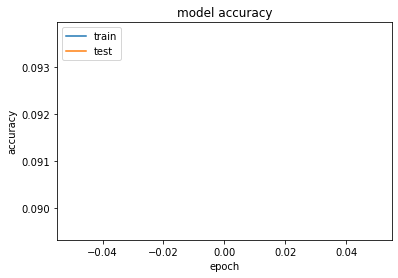

In [25]:
# Plot history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()